In [1]:
from xml.etree import ElementTree
from xml.dom import minidom
import glob, os, sys
from xml.etree.ElementTree import Element, SubElement, Comment
import subprocess as sp
import pandas as pd
from datetime import datetime
from osgeo import ogr
import logging
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.spatial import cKDTree as KDTree
import statsmodels.api as sm
import numpy as np
import pandas as pd
import gdal
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def inRaster(file_raster):
    raster = gdal.Open(file_raster, gdal.GA_ReadOnly)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()
    extent = raster.GetGeoTransform()
    return raster, array, extent

In [3]:
def saveRaster(path, array, raster, datatype=6, formatraster="GTiff"):
    # Set Driver
    format_ = formatraster #save as format
    driver = gdal.GetDriverByName( format_ )
    driver.Register()
    
    # Set Metadata for Raster output
    cols = raster.RasterXSize
    rows = raster.RasterYSize
    bands = raster.RasterCount
    datatype = 6#band.DataType
    
    # Set Projection for Raster
    outDataset = driver.Create(path, cols, rows, bands, datatype)
    geoTransform = raster.GetGeoTransform()
    outDataset.SetGeoTransform(geoTransform)
    proj = raster.GetProjection()
    outDataset.SetProjection(proj)
    
    # Write output to band 1 of new Raster
    outBand = outDataset.GetRasterBand(1)
    outBand.WriteArray(array) #save input array
    #outBand.WriteArray(dem)
    
    # Close and finalise newly created Raster
    #F_M01 = None
    outBand = None
    proj = None
    geoTransform = None
    outDataset = None
    driver = None
    datatype = None
    bands = None
    rows = None
    cols = None
    driver = None
    array = None

In [4]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [5]:
# templateRaster = r'D:\Projects\Pr\3492.10\DIDSLF\asc//DIDSLF_NL_201604010000.asc'
inDataDir  = r'D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif'
for root, dirs, files in os.walk(inDataDir):
    for file in files:
        if file.endswith('.tif'):
            templateRaster = os.path.join( os.path.abspath(root), file )
print (templateRaster)

D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif\DIDSLF_NL_201510310000.tif


In [6]:
# read grid as template for IDW application
raster, array, extent = inRaster(templateRaster)

# Get some metadata from the raster file
band = raster.GetRasterBand(1)
proj = raster.GetProjection()

cols = raster.RasterXSize
rows = raster.RasterYSize

#     # plot as test
#     plt.imshow(array)
#     plt.show()

# create array with all coordinates in array using the extent
x_steps = np.arange(array.shape[1]) * extent[1]
y_steps = np.arange(array.shape[0]) * extent[-1]        
x_coords = extent[0] + x_steps + extent[1]/2
y_coords = extent[3] + y_steps + extent[-1]/2        
xy = cartesian([x_coords, y_coords])
#print ('xy coordinates shape:', xy.shape, '\nlooks like:\n',xy[0:5])

# trans and reshape the template array to a 1D ndarray
#array = array / 86400.
array = array.T
array_rshp = array.reshape(-1)

c:\python35\lib\site-packages\ipykernel\__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\python35\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [7]:
# convert array to pandas dataframe with x/y coordinates
df = pd.DataFrame(xy)
df = pd.concat((df,pd.Series(array_rshp)),axis=1)
df.columns = ['X_RD','Y_RD','InLW']
df['InLW'].replace(array.min(),np.NaN, inplace=True)
df = df[pd.notnull(df['InLW'])]
df.head(), df.shape

(             X_RD           Y_RD        InLW
 579 -15837.582446  301043.650592  25500600.0
 580 -15837.582446  296043.650592  25480800.0
 581 -15837.582446  291043.650592  25358400.0
 582 -15837.582446  286043.650592  25358400.0
 583 -15837.582446  281043.650592  25284600.0, (4388, 3))

In [8]:
df['InLW'] = df['InLW'] / 86400
df.head()

,X_RD,Y_RD,InLW
579,-15837.582446,301043.650592,295.145833
580,-15837.582446,296043.650592,294.916667
581,-15837.582446,291043.650592,293.500000
582,-15837.582446,286043.650592,293.500000
583,-15837.582446,281043.650592,292.645833


In [9]:
tree = KDTree(list(zip(df['X_RD'],df['Y_RD'])), leafsize=11)

In [10]:
# IDW KDTREE
dist, idx = tree.query(xy, k=8, eps=0, p=1)
columns = 'InLW'
tmp = df[[columns]].values.T[:, idx, None]
tmp = np.squeeze(tmp)
weights = (1/dist)**2
q = np.sum(weights, axis=1)
q = q[:,None]
weightsq =  weights / q
wz = np.einsum("ij,ij->i", weightsq, tmp)
#newArray[fr:to] = wz

# combine arrays and reshape to shape array
array_rshp[array_rshp==array_rshp.min()]=np.nan
combine = np.nansum(np.dstack((wz, array_rshp/86400)),2)
outArray = combine.reshape([array.shape[0],array.shape[1]]).T 
array = array.T

c:\python35\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide
c:\python35\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


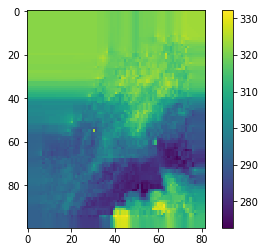

In [11]:
im = plt.imshow(outArray)
plt.colorbar(im, format='%.0f')

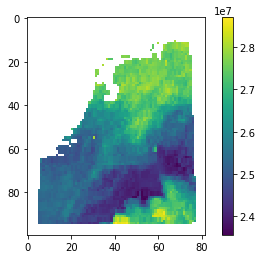

In [12]:
im = plt.imshow(np.ma.masked_where(array == array[0][0],array))
plt.colorbar(im)#, format='%.0i')

In [13]:
# HETZEFLDE MAAR DAN IN ALS BATCH

In [19]:
inDataDir  = r'D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif'
IDWDataDir = r'D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif_IDW'
outDataDir = r'D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif_IDW_100x100m'

In [15]:
for root, dirs, files in os.walk(inDataDir):
    for file in files:
        if file.endswith('.tif'):
            in_file = os.path.join( os.path.abspath(root), file )
            base, extension = os.path.splitext(file)
            
            # read grid as template for IDW application
            raster, array, extent = inRaster(in_file)

            # Get some metadata from the raster file
            band = raster.GetRasterBand(1)
            proj = raster.GetProjection()

            cols = raster.RasterXSize
            rows = raster.RasterYSize

            #     # plot as test
            #     plt.imshow(array)
            #     plt.show()

            # create array with all coordinates in array using the extent
            x_steps = np.arange(array.shape[1]) * extent[1]
            y_steps = np.arange(array.shape[0]) * extent[-1]        
            x_coords = extent[0] + x_steps + extent[1]/2
            y_coords = extent[3] + y_steps + extent[-1]/2        
            xy = cartesian([x_coords, y_coords])
            #print ('xy coordinates shape:', xy.shape, '\nlooks like:\n',xy[0:5])

            # trans and reshape the template array to a 1D ndarray
            array = array.T
            array_rshp = array.reshape(-1)    

            # convert array to pandas dataframe with x/y coordinates
            df = pd.DataFrame(xy)
            df = pd.concat((df,pd.Series(array_rshp)),axis=1)
            df.columns = ['X_RD','Y_RD','InLW']
            df['InLW'].replace(array.min(),np.NaN, inplace=True)
            df = df[pd.notnull(df['InLW'])]
            df['InLW'] = df['InLW'] / 86400
            #df.head(), df.shape            
            
            # create the three
            tree = KDTree(list(zip(df['X_RD'],df['Y_RD'])), leafsize=11)
            
            # IDW KDTREE
            dist, idx = tree.query(xy, k=8, eps=0, p=1)
            columns = 'InLW'
            tmp = df[[columns]].values.T[:, idx, None]
            tmp = np.squeeze(tmp)
            weights = (1/dist)**2
            q = np.sum(weights, axis=1)
            q = q[:,None]
            weightsq =  weights / q
            wz = np.einsum("ij,ij->i", weightsq, tmp)
            #newArray[fr:to] = wz

            # combine arrays and reshape to shape array
            array_rshp[array_rshp==array_rshp.min()]=np.nan
            combine = np.nansum(np.dstack((wz, array_rshp / 86400)),2) # apply conversion from J/cm to W/m
            outArray = combine.reshape([array.shape[0],array.shape[1]]).T 
            array = array.T
            
            # save the raster
            out_file = os.path.join(IDWDataDir,base+'.tif')
            print(out_file)
            saveRaster(out_file, outArray, raster)

c:\python35\lib\site-packages\ipykernel\__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\python35\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\python35\lib\site-packages\ipykernel\__main__.py:50: RuntimeWarning: divide by zero encountered in true_divide
c:\python35\lib\site-packages\ipykernel\__main__.py:53: RuntimeWarning: invalid value encountered in true_divide


D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif_IDW\DIDSLF_NL_201504010000.tif
D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif_IDW\DIDSLF_NL_201504020000.tif
D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif_IDW\DIDSLF_NL_201504030000.tif
D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif_IDW\DIDSLF_NL_201504040000.tif
D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif_IDW\DIDSLF_NL_201504050000.tif
D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif_IDW\DIDSLF_NL_201504060000.tif
D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif_IDW\DIDSLF_NL_201504070000.tif
D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif_IDW\DIDSLF_NL_201504080000.tif
D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif_IDW\DIDSLF_NL_201504090000.tif
D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif_IDW\DIDSLF_NL_201504100000.tif
D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\t

In [16]:
# VERVOLGENS DOE BILINEAR INTERPOLEREN NAAR 100x100 METER

In [20]:
gdalwarp   = r'C:\Python35\Lib\site-packages\osgeo//gdalwarp.exe'
# IDWDataDir = r'D:\Projects\Pr\3492.10\DIDSLF\tif_IDW'
# outDataDir = r'D:\Projects\Pr\3492.10\DIDSLF\tif_IDW_100x100m'

In [21]:
for root, dirs, files in os.walk(IDWDataDir):
    for file in files:
        if file.endswith('.tif'):
            in_file = os.path.join( os.path.abspath(root), file )
            base, extension = os.path.splitext(file)
            #print (base)
            out_file = os.path.join(outDataDir,base+'.tif')
            #print (out_file)
            # resample raster to 100x100m using bilinear interpolation
            command = [gdalwarp, '-overwrite', '-s_srs', 'EPSG:28992', '-t_srs', 'EPSG:28992', '-r', 'bilinear', 
                       '-wm', '200', '-tr', '100', '100', '-te', '0.0', '275000.0', '299000.0', '630000.0',
                       '-multi', in_file, out_file]          
            print (sp.list2cmdline(command))
            norm = sp.Popen(sp.list2cmdline(command),stdout=sp.PIPE, shell=True)
            norm.communicate()            

C:\Python35\Lib\site-packages\osgeo//gdalwarp.exe -overwrite -s_srs EPSG:28992 -t_srs EPSG:28992 -r bilinear -wm 200 -tr 100 100 -te 0.0 275000.0 299000.0 630000.0 -multi "D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif_IDW\DIDSLF_NL_201504010000.tif" "D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif_IDW_100x100m\DIDSLF_NL_201504010000.tif"
C:\Python35\Lib\site-packages\osgeo//gdalwarp.exe -overwrite -s_srs EPSG:28992 -t_srs EPSG:28992 -r bilinear -wm 200 -tr 100 100 -te 0.0 275000.0 299000.0 630000.0 -multi "D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif_IDW\DIDSLF_NL_201504020000.tif" "D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif_IDW_100x100m\DIDSLF_NL_201504020000.tif"
C:\Python35\Lib\site-packages\osgeo//gdalwarp.exe -overwrite -s_srs EPSG:28992 -t_srs EPSG:28992 -r bilinear -wm 200 -tr 100 100 -te 0.0 275000.0 299000.0 630000.0 -multi "D:\jupyter\PR3492.10 Eact LSA-SAF\Toegepast op 2015\DIDSLF\tif_IDW\DIDSLF_NL_2015040